In [1]:
from Initialization_multi_element import *

c:\libs\pycqed_py3\data
Data directory set to: c:\libs\pycqed_py3\data
c:\libs\pycqed_py3\data
Connected to: SONY/TEK AWG520 (serial:0, firmware:SCPI:95.0 OS:1.0 USR:1.3a) in 0.09s
Connected to: Agilent Technologies N5183B (serial:MY53271678, firmware:B.01.60) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/101645, firmware:3.1.19.15-3.50.124.67) in 0.02s


c:\libs\qcodes\qcodes\instrument\parameter.py:247: UserWarning:

Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.

Snapshot: Could not update parameter: clock_source on ATS
Snapshot: Could not update parameter: sample_rate on ATS
Snapshot: Could not update parameter: clock_edge on ATS
Snapshot: Could not update parameter: decimation on ATS
Snapshot: Could not update parameter: coupling1 on ATS
Snapshot: Could not update parameter: channel_range1 on ATS
Snapshot: Could not update parameter: impedance1 on ATS
Snapshot: Could not update parameter: bwlimit1 on ATS
Snapshot: Could not update parameter: coupling2 on ATS
Snapshot: Could not update parameter: channel_range2 on ATS
Snapshot: Could not update parameter: impedance2 on ATS
Snapshot: Could not update parameter: bwlimit2 on ATS
Snapshot: Could not update parameter: trigger_operation on ATS
Snapshot: Could not update parameter: trigger_engine1 on A

controller initialized


In [2]:
station.components

{'RFLO': <N51x1: RFLO>,
 'SPEC': <RohdeSchwarz_SGS100A: SPEC>,
 'ATS': <AlazarTech_ATS9870: ATS>,
 'ATS_controller_multi_element': <Demodulation_AcquisitionController: ATS_controller_multi_element>,
 'HS': <HeterodyneInstrument: HS>,
 'MC': <MeasurementControl: MC>}

In [3]:
RFLO.on()

In [13]:
SPEC.power(-5)
SPEC.IQ_state('ON')  
SPEC.frequency(6.16e9-0.05e9)
SPEC.on()

In [4]:
RFLO.power(13.0)
RFLO.frequency(6.16e9)

In [5]:
ATS.config(clock_source='INTERNAL_CLOCK',
                sample_rate=1e9,
                clock_edge='CLOCK_EDGE_RISING',
                decimation=0,
                coupling=['DC','DC'],
                channel_range=[0.1,0.1],
                impedance=[50,50],
                bwlimit=['DISABLED','DISABLED'],
                trigger_operation='TRIG_ENGINE_OP_J',
                trigger_engine1='TRIG_ENGINE_J',
                trigger_source1='EXTERNAL',
                trigger_slope1='TRIG_SLOPE_POSITIVE',
                trigger_level1=128,
                trigger_engine2='TRIG_ENGINE_K',
                trigger_source2='DISABLE',
                trigger_slope2='TRIG_SLOPE_POSITIVE',
                trigger_level2=128,
                external_trigger_coupling='AC',
                external_trigger_range='ETR_5V',
                trigger_delay=0,
                timeout_ticks=0
)

In [14]:
# configure the ATS controller
ATS_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=4096,
                 records_per_buffer=21*300,#70, segmments
                 buffers_per_acquisition=5,
                 channel_selection='AB',
                 transfer_offset=0,
                 external_startcapture='ENABLED',
                 enable_record_headers='DISABLED',
                 alloc_buffers='DISABLED',
                 fifo_only_streaming='DISABLED',
                 interleave_samples='DISABLED',
                 get_processed_data='DISABLED',
                 allocated_buffers=5,  
                 buffer_timeout=5000,
)


In [6]:
ATS_controller.awgcontrol(amp=0.2,seq='rabi_sequence_int_scan_FILE.seq')

In [49]:
ATS_controller.awgstart()

In [8]:
def ATS_homodyne_acquisition_multielements(integration_start, integration_time, Numer_of_elements, Numer_of_avg):

    integration_end = integration_start + integration_time
    ATS.external_trigger_coupling._set_updated()
    ATS.external_trigger_range._set_updated()
    
    ATS_controller.pre_acquire()
    blub = ATS_controller.do_acquisition()
    ATS_controller.post_acquire()

    buffer = ATS_controller.buffer
    reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer() , ATS.samples_per_record())/ATS.allocated_buffers()-128.


# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[:50]])

    for i in range(Numer_of_elements):
        average_record_I[i] = np.average(reshaped_buffer[0][i::Numer_of_elements], axis = 0)
        average_record_Q[i] = np.average(reshaped_buffer[1][i::Numer_of_elements], axis = 0)


    offset_I=np.zeros(Numer_of_elements)
    offset_Q=np.zeros(Numer_of_elements)
    integrated_output_I=np.zeros(Numer_of_elements)
    integrated_output_Q=np.zeros(Numer_of_elements)

    
    for i in range(Numer_of_elements):
        offset_I[i] = np.average(average_record_I[i][3000:4000])
        offset_Q[i] = np.average(average_record_Q[i][3000:4000])
        integrated_output_I[i] = np.average(average_record_I[i][integration_start:integration_end])-offset_I[i]#/range_I
        integrated_output_Q[i] = np.average(average_record_Q[i][integration_start:integration_end])-offset_Q[i]#/range_Q
      
    
#     range_I = np.max(average_record_I[integration_start:integration_end]) \
#              -np.min(average_record_I[integration_start:integration_end])
   
#     range_Q = np.max(average_record_Q[integration_start:integration_end]) \
#              -np.min(average_record_Q[integration_start:integration_end])
    
    return [integrated_output_I, integrated_output_Q]

In [9]:
def ATS_homodyne_acquisition(integration_start, integration_time):
    
    integration_end = integration_start + integration_time
    ATS.external_trigger_coupling._set_updated()
    ATS.external_trigger_range._set_updated()
    
    ATS_controller.pre_acquire()
    blub = ATS_controller.do_acquisition()
    ATS_controller.post_acquire()

    buffer = ATS_controller.buffer
    reshaped_buffer = buffer.reshape(2, ATS.records_per_buffer(), ATS.samples_per_record())-128.

#     print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
#     print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[:50]])

    average_record_I = np.average(reshaped_buffer[0,:,:], axis = 0)
    average_record_Q = np.average(reshaped_buffer[1,:,:], axis = 0)
    
    offset_I = np.average(average_record_I[3000:4000])
    offset_Q = np.average(average_record_Q[3000:4000])
    
#     range_I = np.max(average_record_I[integration_start:integration_end]) \
#              -np.min(average_record_I[integration_start:integration_end])
   
#     range_Q = np.max(average_record_Q[integration_start:integration_end]) \
#              -np.min(average_record_Q[integration_start:integration_end])
    
    integrated_output_I = np.average(average_record_I[integration_start:integration_end]-offset_I)#/range_I
    integrated_output_Q = np.average(average_record_Q[integration_start:integration_end]-offset_Q)#/range_Q
    
    return [integrated_output_I, integrated_output_Q]

In [12]:
ATS_controller.awgcontrol(amp=1.0,seq='rabi_sequence_amp_scan_FILE.seq')

6.72025533333
3.779536


(0, 4000)

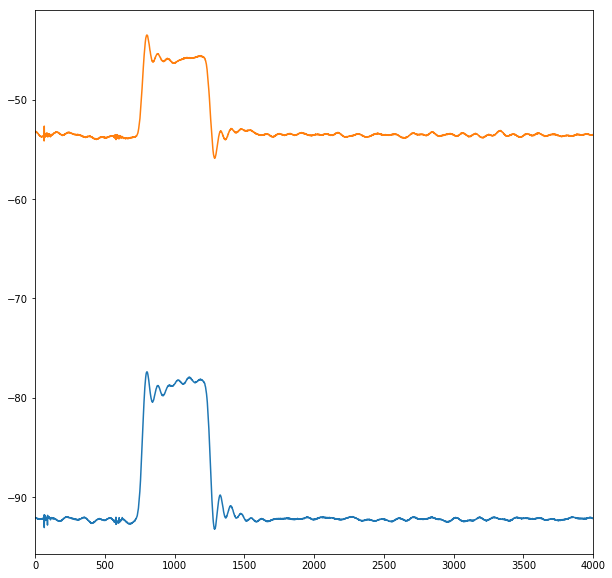

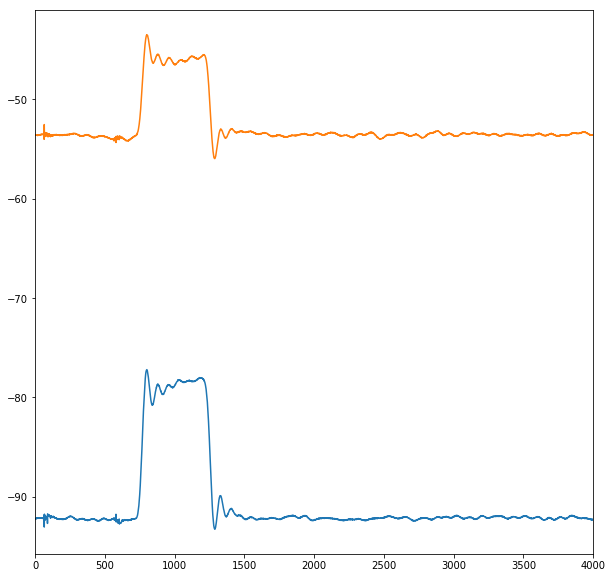

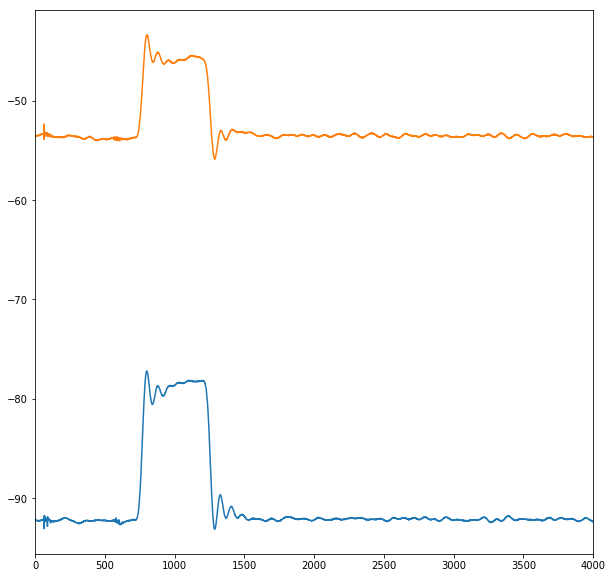

In [50]:
integration_start=674
integration_end=integration_start+1000

RFLO.frequency(6.157e9)
SPEC.frequency(6.157e9+0.05e9)
SPEC.power(0)
SPEC.off()
ATS.external_trigger_coupling._set_updated()
ATS.external_trigger_range._set_updated()
RFLO.on()
Numer_of_elements = 21
Numer_of_avg = 300

ATS_controller.pre_acquire()
ATS_controller.do_acquisition()
ATS_controller.post_acquire()

buffer = ATS_controller.buffer
reshaped_buffer = buffer.reshape(2, Numer_of_avg, Numer_of_elements , ATS.samples_per_record())/ATS.allocated_buffers()-128.

# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[-50:]])
# print(reshaped_buffer.flatten()[np.argsort(reshaped_buffer.flatten())[:50]])

offset_I=np.zeros(Numer_of_elements)
offset_Q=np.zeros(Numer_of_elements)
integrated_output_I=np.zeros(Numer_of_elements)
integrated_output_Q=np.zeros(Numer_of_elements)

for i in range(Numer_of_elements):
    average_record_I = np.average(reshaped_buffer[0][:,:,:], axis = 0)
    average_record_Q = np.average(reshaped_buffer[1][:,:,:], axis = 0)

    
for i in range(Numer_of_elements):
    offset_I[i] = np.average(average_record_I[i][3000:4000])
    offset_Q[i] = np.average(average_record_Q[i][3000:4000])
    integrated_output_I[i] = np.average(average_record_I[i][integration_start:integration_end])-offset_I[i]#/range_I
    integrated_output_Q[i] = np.average(average_record_Q[i][integration_start:integration_end])-offset_Q[i]#/range_Q


# integrated_output_power = np.average((average_record_I[integration_start:integration_end]
#                                      +average_record_Q[integration_start:integration_end])**2)
# integrated_output_power = np.average(((average_record_I[integration_start:integration_end])**2
#                                      +(average_record_Q[integration_start:integration_end])**2))**0.5

print(integrated_output_I[2])
print(integrated_output_Q[2])


plt.figure(figsize=(10,10))
plt.plot(average_record_I[0])
plt.plot(average_record_Q[0])
plt.xlim(0, 4000)

plt.figure(figsize=(10,10))
plt.plot(average_record_I[10])
plt.plot(average_record_Q[10])
plt.xlim(0, 4000)

plt.figure(figsize=(10,10))
plt.plot(average_record_I[20])
plt.plot(average_record_Q[20])
plt.xlim(0, 4000)

# T1 measurement

In [157]:
ATS_controller.awgcontrol(amp=1.2,seq='T1_delay_scan_FILE.seq')

In [158]:
ATS_controller.awgstop()

In [ ]:
# time_delay=np.linspace(100e-9,2.1e-6,21)

In [159]:
#5-buffer measurement.2019.03.27.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=800
integration_time=500

T1_integrated_output_I = np.zeros((Numer_of_elements))
T1_integrated_output_Q = np.zeros((Numer_of_elements))

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9-0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.15805e9)  
length=100

for ii in range(0,length):
    print(ii)
    ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
    for i in range(0,Numer_of_elements):
        T1_integrated_output_I[i]=T1_integrated_output_I[i]+ATS_Tempo[0][i]
        T1_integrated_output_Q[i]=T1_integrated_output_Q[i]+ATS_Tempo[1][i]

T1_integrated_output_I = T1_integrated_output_I/length
T1_integrated_output_Q = T1_integrated_output_Q/length

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


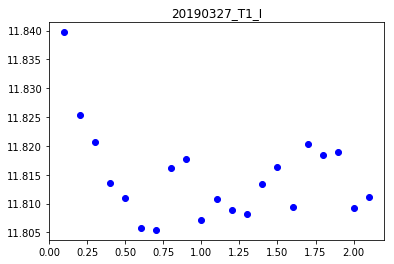

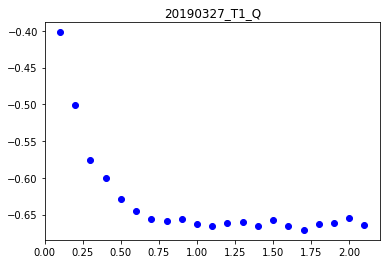

In [160]:
time_delay=np.linspace(0.1,2.1,21)
plt.figure()
plt.title('20190327_T1_I')
plt.plot(time_delay, T1_integrated_output_I,'bo')
plt.savefig('T1_W2-3D_HF_20190327_I.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title('20190327_T1_Q')
plt.plot(time_delay, T1_integrated_output_Q,'bo')
plt.savefig('T1_W2-3D_HF_20190327_Q.png', dpi=300, bbox_inches='tight')

[[Model]]
    Model(decay)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 21
    # variables        = 3
    chi-square         = 3.7779e-04
    reduced chi-square = 2.0989e-05
    Akaike info crit   = -223.439340
    Bayesian info crit = -220.305773
[[Variables]]
    amp:     0.43956876 +/- 0.01216720 (2.77%) (init = 0.2)
    T1:      0.19464165 +/- 0.00648393 (3.33%) (init = 0.2)
    offset: -0.66317252 +/- 0.00126830 (0.19%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, T1)     = -0.828
    C(T1, offset)  = -0.483
    C(amp, offset) =  0.187



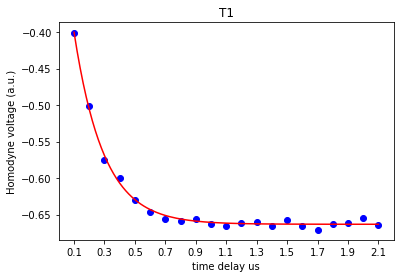

In [161]:
from lmfit import Model 
def decay(x, amp, T1,offset):
    return amp*np.exp(-x/T1)+offset

f=time_delay
f0=np.linspace(0.1,2.1,201)
y=T1_integrated_output_Q

gmodel = Model(decay)
result = gmodel.fit(y,x=f,amp=0.2,T1=0.2,offset=0.0)

print(result.fit_report())

plt.figure()
plt.plot(f, y, 'bo')
plt.plot(f0, decay(f0,result.best_values['amp'],result.best_values['T1'],result.best_values['offset']), 'r-')
plt.xlim(0, 2.2)
plt.title('T1')
plt.xlabel('time delay us')
plt.ylabel('Homodyne voltage (a.u.)')
plt.xticks(np.linspace(0.1,2.1,11))
plt.savefig('T1_fit_W2-3D_HF_20190327_Q.png', dpi=300, bbox_inches='tight')

In [162]:
print(time_delay)
print(T1_integrated_output_I)
print(T1_integrated_output_Q)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5
  1.6  1.7  1.8  1.9  2.   2.1]
[ 11.83971133  11.82531419  11.82059733  11.81350304  11.81092652
  11.80582591  11.80543691  11.81616901  11.81777731  11.80714917
  11.81079787  11.80892171  11.80825387  11.81343959  11.81642877
  11.80945333  11.820377    11.81838987  11.81893297  11.80928012
  11.81114825]
[-0.40185586 -0.50093189 -0.57527735 -0.60034016 -0.62938402 -0.64573383
 -0.65594455 -0.65850099 -0.6558976  -0.66226876 -0.66570035 -0.66091453
 -0.66014415 -0.66517034 -0.65677915 -0.66494715 -0.67090964 -0.66261083
 -0.66115583 -0.65401672 -0.66361583]


In [163]:
#5-buffer measurement.2019.03.27.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=800
integration_time=500

T1_integrated_output_I2 = np.zeros((Numer_of_elements))
T1_integrated_output_Q2 = np.zeros((Numer_of_elements))

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9-0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.15805e9)  
length=200

for ii in range(0,length):
    print(ii)
    ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
    for i in range(0,Numer_of_elements):
        T1_integrated_output_I2[i]=T1_integrated_output_I2[i]+ATS_Tempo[0][i]
        T1_integrated_output_Q2[i]=T1_integrated_output_Q2[i]+ATS_Tempo[1][i]

T1_integrated_output_I2 = T1_integrated_output_I2/length
T1_integrated_output_Q2 = T1_integrated_output_Q2/length

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


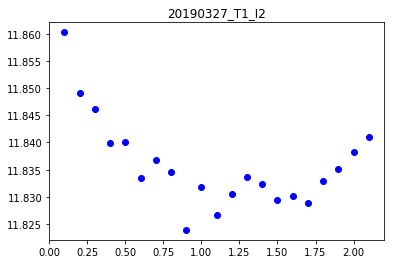

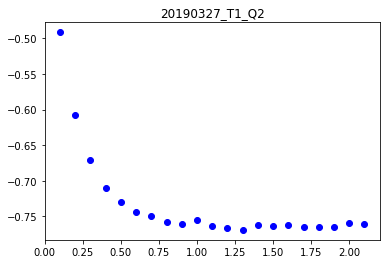

In [164]:
time_delay=np.linspace(0.1,2.1,21)
plt.figure()
plt.title('20190327_T1_I2')
plt.plot(time_delay, T1_integrated_output_I2,'bo')
plt.savefig('T1_W2-3D_HF_20190327_I2.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title('20190327_T1_Q2')
plt.plot(time_delay, T1_integrated_output_Q2,'bo')
plt.savefig('T1_W2-3D_HF_20190327_Q2.png', dpi=300, bbox_inches='tight')

[[Model]]
    Model(decay)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 21
    # variables        = 3
    chi-square         = 1.3486e-04
    reduced chi-square = 7.4924e-06
    Akaike info crit   = -245.071246
    Bayesian info crit = -241.937679
[[Variables]]
    amp:     0.46376618 +/- 0.00766960 (1.65%) (init = 0.2)
    T1:      0.18615910 +/- 0.00362743 (1.95%) (init = 0.2)
    offset: -0.76330820 +/- 7.4837e-04 (0.10%) (init = 1.61)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, T1)     = -0.837
    C(T1, offset)  = -0.471
    C(amp, offset) =  0.188



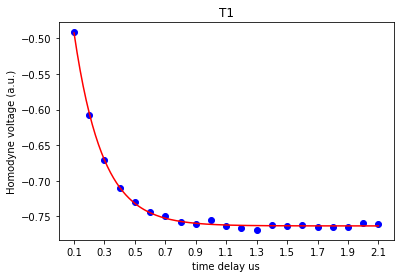

In [165]:
from lmfit import Model 
def decay(x, amp, T1,offset):
    return amp*np.exp(-x/T1)+offset

f=time_delay
f0=np.linspace(0.1,2.1,201)
y=T1_integrated_output_Q2

gmodel = Model(decay)
result = gmodel.fit(y,x=f,amp=0.2,T1=0.2,offset=1.61)

print(result.fit_report())

plt.figure()
plt.plot(f, y, 'bo')
plt.plot(f0, decay(f0,result.best_values['amp'],result.best_values['T1'],result.best_values['offset']), 'r-')
plt.xlim(0, 2.2)
plt.title('T1')
plt.xlabel('time delay us')
plt.ylabel('Homodyne voltage (a.u.)')
plt.xticks(np.linspace(0.1,2.1,11))
plt.savefig('T1_fit_W2-3D_HF_20190327_Q2.png', dpi=300, bbox_inches='tight')

In [166]:
print(time_delay)
print(T1_integrated_output_I2)
print(T1_integrated_output_Q2)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5
  1.6  1.7  1.8  1.9  2.   2.1]
[ 11.86026276  11.84911392  11.84618905  11.83997575  11.84003232
  11.83345471  11.83674593  11.834534    11.82393381  11.83182033
  11.82673131  11.83053768  11.83367961  11.83243702  11.82935301
  11.83022236  11.82880865  11.83289595  11.83515887  11.83826016
  11.84093484]
[-0.49128863 -0.60713707 -0.67014066 -0.710481   -0.73009768 -0.74416206
 -0.75002542 -0.75716364 -0.76030528 -0.75502781 -0.76319423 -0.76618258
 -0.76893011 -0.76258657 -0.76322219 -0.76191105 -0.76511265 -0.76433446
 -0.76526034 -0.75950413 -0.76129191]


# T2 measurement

In [167]:
ATS_controller.awgcontrol(amp=1.2,seq='T2_delay_scan_FILE.seq')

In [168]:
ATS_controller.awgstop()

In [149]:
#5-buffer measurement.2019.03.27.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=800
integration_time=500

T2_integrated_output_I = np.zeros((Numer_of_elements))
T2_integrated_output_Q = np.zeros((Numer_of_elements))

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9-0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.15805e9)  
length=100

for ii in range(0,length):
    print(ii)
    ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
    for i in range(0,Numer_of_elements):
        T2_integrated_output_I[i]=T2_integrated_output_I[i]+ATS_Tempo[0][i]
        T2_integrated_output_Q[i]=T2_integrated_output_Q[i]+ATS_Tempo[1][i]

T2_integrated_output_I = T2_integrated_output_I/length
T2_integrated_output_Q = T2_integrated_output_Q/length

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


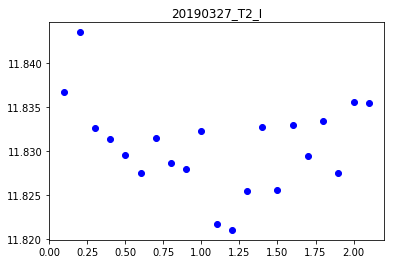

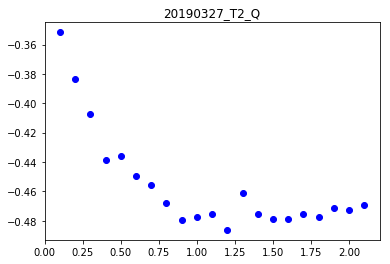

In [150]:
time_delay=np.linspace(0.1,2.1,21)#us
plt.figure()
plt.title('20190327_T2_I')
plt.plot(time_delay, T2_integrated_output_I,'bo')
plt.savefig('T2_W2-3D_HF_20190327_I.png', dpi=300, bbox_inches='tight')

plt.figure()
plt.title('20190327_T2_Q')
plt.plot(time_delay, T2_integrated_output_Q,'bo')
plt.savefig('T2_W2-3D_HF_20190327_Q.png', dpi=300, bbox_inches='tight')

[[Model]]
    Model(Ramsey)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 59
    # data points      = 21
    # variables        = 4
    chi-square         = 6.9227e-04
    reduced chi-square = 4.0722e-05
    Akaike info crit   = -208.721209
    Bayesian info crit = -204.543120
[[Variables]]
    amp:       0.15343596 +/- 0.01337222 (8.72%) (init = 0.2)
    T2:        0.41607164 +/- 0.06562565 (15.77%) (init = 0.2)
    detuning: -0.27890739 +/- 0.04448577 (15.95%) (init = 0.2)
    offset:   -0.47213795 +/- 0.00292066 (0.62%) (init = 1.61)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, T2)          = -0.881
    C(detuning, offset) = -0.844
    C(T2, detuning)     = -0.710
    C(amp, offset)      = -0.670
    C(T2, offset)       =  0.657
    C(amp, detuning)    =  0.602



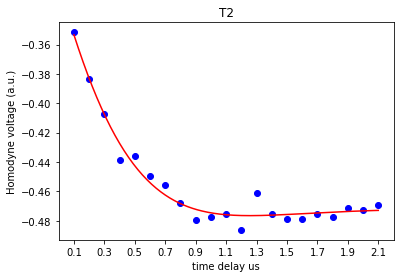

In [151]:
from lmfit import Model 
def Ramsey(x, amp, T2, detuning, offset):
    return amp*np.exp(-x/T2)*np.cos(2*np.pi*x*detuning)+offset

t=time_delay
t0=np.linspace(0.1,2.1,201)
y=T2_integrated_output_Q

gmodel = Model(Ramsey)
result = gmodel.fit(y,x=t,amp=0.2,T2=0.2,detuning=0.2,offset=1.61)

print(result.fit_report())

plt.figure()
plt.plot(t, y, 'bo')
plt.plot(t0, Ramsey(f0,result.best_values['amp'],result.best_values['T2'],result.best_values['detuning'],result.best_values['offset']), 'r-')
plt.xlim(0, 2.2)
plt.title('T2')
plt.xlabel('time delay us')
plt.ylabel('Homodyne voltage (a.u.)')
plt.xticks(np.linspace(0.1,2.1,11))
plt.savefig('T2_fit_W2-3D_HF_20190327_Q.png', dpi=300, bbox_inches='tight')

In [169]:
print(time_delay)
print(T2_integrated_output_I)
print(T2_integrated_output_Q)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5
  1.6  1.7  1.8  1.9  2.   2.1]
[ 11.83670709  11.84352071  11.83265859  11.83135003  11.82956271
  11.82747794  11.83148829  11.82860409  11.82794619  11.83231153
  11.82172287  11.82104031  11.82545347  11.83273917  11.82558409
  11.83297794  11.82947479  11.83338561  11.82745937  11.83555613
  11.83549816]
[-0.351613   -0.38334562 -0.40761383 -0.43885817 -0.43600232 -0.44976427
 -0.45587403 -0.4678125  -0.47973581 -0.47764169 -0.47571904 -0.48628525
 -0.46114341 -0.47560447 -0.47910823 -0.47870993 -0.47539443 -0.47714843
 -0.47118643 -0.47263793 -0.46963127]


In [170]:
#5-buffer measurement.2019.03.27.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=800
integration_time=500

T2_integrated_output_I2 = np.zeros((Numer_of_elements))
T2_integrated_output_Q2 = np.zeros((Numer_of_elements))

SPEC.power.set(-10.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9-0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.15805e9)  
length=200

for ii in range(0,length):
    print(ii)
    ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
    for i in range(0,Numer_of_elements):
        T2_integrated_output_I2[i]=T2_integrated_output_I2[i]+ATS_Tempo[0][i]
        T2_integrated_output_Q2[i]=T2_integrated_output_Q2[i]+ATS_Tempo[1][i]

T2_integrated_output_I2 = T2_integrated_output_I2/length
T2_integrated_output_Q2 = T2_integrated_output_Q2/length

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


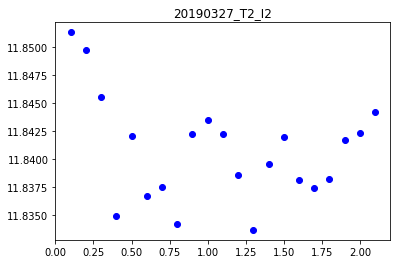

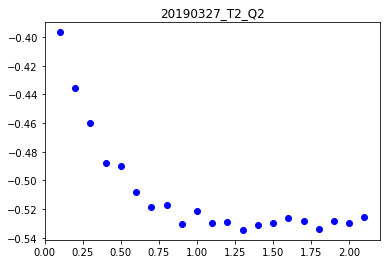

In [171]:
time_delay=np.linspace(0.1,2.1,21)#us
plt.figure()
plt.title('20190327_T2_I2')
plt.plot(time_delay, T2_integrated_output_I2,'bo')
plt.savefig('T2_W2-3D_HF_20190327_I2.png', dpi=300, bbox_inches='tight')

plt.figure()  
plt.title('20190327_T2_Q2')
plt.plot(time_delay, T2_integrated_output_Q2,'bo')
plt.savefig('T2_W2-3D_HF_20190327_Q2.png', dpi=300, bbox_inches='tight')

[[Model]]
    Model(Ramsey)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 21
    # variables        = 3
    chi-square         = 3.0051e-04
    reduced chi-square = 1.6695e-05
    Akaike info crit   = -228.245662
    Bayesian info crit = -225.112095
[[Variables]]
    amp:     0.19207063 +/- 0.00723807 (3.77%) (init = 0.2)
    T2:      0.28657633 +/- 0.01578204 (5.51%) (init = 0.5)
    offset: -0.53097910 +/- 0.00132227 (0.25%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, T2)     = -0.746
    C(T2, offset)  = -0.610
    C(amp, offset) =  0.178



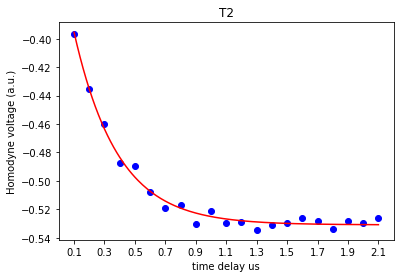

In [184]:
from lmfit import Model 
# def Ramsey(x, amp, T2, detuning, phase, offset):
#     return amp*np.exp(-x/T2)*np.cos(2*np.pi*x*detuning+2*np.pi*phase)+offset
def Ramsey(x, amp, T2,offset):
    return amp*np.exp(-x/T2)+offset

t=time_delay
t0=np.linspace(0.1,2.1,201)
y=T2_integrated_output_Q2

gmodel = Model(Ramsey)
# result = gmodel.fit(y,x=t,amp=0.2,T2=0.4,detuning=0.1,phase=0,offset=0.1)
result = gmodel.fit(y,x=t,amp=0.2,T2=0.5,offset=0.1)

print(result.fit_report())

plt.figure()
plt.plot(t, y, 'bo')
# plt.plot(t0, Ramsey(f0,result.best_values['amp'],result.best_values['T2'],result.best_values['detuning'],result.best_values['phase'],result.best_values['offset']), 'r-')
plt.plot(t0, Ramsey(f0,result.best_values['amp'],result.best_values['T2'],result.best_values['offset']), 'r-')
plt.xlim(0, 2.2)
plt.title('T2')
plt.xlabel('time delay us')
plt.ylabel('Homodyne voltage (a.u.)')
plt.xticks(np.linspace(0.1,2.1,11))
plt.savefig('T2_fit_W2-3D_HF_20190327_Q2.png', dpi=300, bbox_inches='tight')

In [183]:
print(time_delay)
print(T2_integrated_output_I2)
print(T2_integrated_output_Q2)

[ 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5
  1.6  1.7  1.8  1.9  2.   2.1]
[ 11.85131956  11.84974738  11.84556023  11.83494994  11.84206896
  11.83675133  11.83755171  11.83419973  11.8422824   11.84352178
  11.84226931  11.83862556  11.83370818  11.83959154  11.84196097
  11.83818233  11.83740712  11.83828512  11.84169365  11.84235805
  11.84424996]
[-0.39657695 -0.43563869 -0.46006018 -0.48749555 -0.4896247  -0.50800492
 -0.51879584 -0.51708944 -0.53047531 -0.52128064 -0.52981735 -0.52869213
 -0.53452811 -0.53123273 -0.52952406 -0.52592626 -0.52842831 -0.53374404
 -0.52834999 -0.52980916 -0.5258014 ]


# Multi-element Rabi oscillation

In [92]:
ATS_controller.awgcontrol(amp=0.2,seq='rabi_sequence_int_scan_FILE.seq')

In [93]:
ATS_controller.awgstop()

In [94]:
#5 buffer,2019.03.27.
Numer_of_elements = 21
Numer_of_avg = 300

integration_start=800
integration_time=500

rabi_integrated_output_I = np.zeros((Numer_of_elements))
rabi_integrated_output_Q = np.zeros((Numer_of_elements))

SPEC.power.set(-16.0)
SPEC.on()
SPEC.IQ_state.set('ON') 
SPEC.frequency.set(6.7236e9+0.05e9)
RFLO.on()
RFLO.power(13.0)
RFLO.frequency.set(6.158e9)  
length=100

for ii in range(0,length):
    print(ii)
    ATS_Tempo=ATS_homodyne_acquisition_multielements(integration_start,integration_time,Numer_of_elements,Numer_of_avg)
    for i in range(0,Numer_of_elements):
        rabi_integrated_output_I[i]=rabi_integrated_output_I[i]+ATS_Tempo[0][i]
        rabi_integrated_output_Q[i]=rabi_integrated_output_Q[i]+ATS_Tempo[1][i]

rabi_integrated_output_I = rabi_integrated_output_I/length
rabi_integrated_output_Q = rabi_integrated_output_Q/length

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


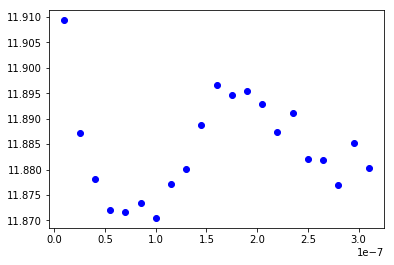

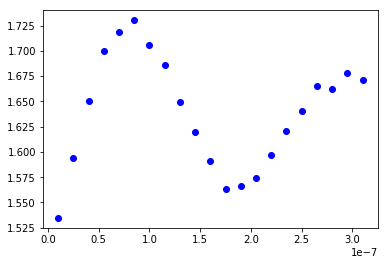

In [95]:
pulse_length=[  1.00000000e-08,   2.50000000e-08,   4.00000000e-08,
         5.50000000e-08,   7.00000000e-08,   8.50000000e-08,
         1.00000000e-07,   1.15000000e-07,   1.30000000e-07,
         1.45000000e-07,   1.60000000e-07,   1.75000000e-07,
         1.90000000e-07,   2.05000000e-07,   2.20000000e-07,
         2.35000000e-07,   2.50000000e-07,   2.65000000e-07,
         2.80000000e-07,   2.95000000e-07,   3.10000000e-07]
plt.figure()
plt.plot(pulse_length, rabi_integrated_output_I,'bo')
plt.figure()
plt.plot(pulse_length, rabi_integrated_output_Q,'bo')